# CC3182 – Visión por Computadora
## Laboratorio 5 – Paralaje y Estereoscopía

**Configuración correcta:** Imagen Izquierda = Train (Base/Destino) | Imagen Derecha = Query (Origen/A transformar)

## 0. Instalación e imports

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
from IPython.display import display, HTML
import io
from PIL import Image
%matplotlib inline

In [40]:
CONTROL_LEFT  = 'control_izq.jpg'
CONTROL_RIGHT = 'control_der.jpg'
EXP_LEFT      = 'exp_izq.jpg'
EXP_RIGHT     = 'exp_der.jpg'


def load_img(path):
    img = cv2.imread(path)
    assert img is not None, f"No se encontró: {path}"
    return img

ctrl_left  = load_img(CONTROL_LEFT)
ctrl_right = load_img(CONTROL_RIGHT)
exp_left   = load_img(EXP_LEFT)
exp_right  = load_img(EXP_RIGHT)
print("Imágenes cargadas correctamente ✓")

Imágenes cargadas correctamente ✓


---
## 2. Función de Stitching
**Left = Train (Base)** | **Right = Query (se transforma)**

In [41]:
def stitch_images(img_left, img_right, ratio_thresh=0.7, ransac_thresh=5.0, show_matches=True):
    """
    img_left  = Train (Base) — se queda fija
    img_right = Query        — se transforma hacia el espacio de left
    Retorna: (panorama, img_warped_right, offset_x, offset_y)
    """
    gray_left  = cv2.cvtColor(img_left,  cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp_left,  des_left  = sift.detectAndCompute(gray_left,  None)
    kp_right, des_right = sift.detectAndCompute(gray_right, None)
    print(f"Keypoints — Izq (Train): {len(kp_left)} | Der (Query): {len(kp_right)}")

    FLANN_INDEX_KDTREE = 1
    flann = cv2.FlannBasedMatcher(
        dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
        dict(checks=50)
    )
    # Query = derecha, Train = izquierda
    matches = flann.knnMatch(des_right, des_left, k=2)
    good = [m for m, n in matches if m.distance < ratio_thresh * n.distance]
    print(f"Buenos matches: {len(good)}")

    if len(good) < 4:
        raise ValueError("Pocos matches. Verifica las imágenes.")

    if show_matches:
        img_m = cv2.drawMatches(img_right, kp_right, img_left, kp_left, good, None, flags=2)
        plt.figure(figsize=(16, 5))
        plt.imshow(cv2.cvtColor(img_m, cv2.COLOR_BGR2RGB))
        plt.title(f'Matches: {len(good)}')
        plt.axis('off'); plt.tight_layout(); plt.show()

    # Homografía: right → left
    src_pts = np.float32([kp_right[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_left[m.trainIdx].pt  for m in good]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
    print(f"Inliers RANSAC: {mask.ravel().sum()}/{len(good)}")

    h_l, w_l = img_left.shape[:2]
    h_r, w_r = img_right.shape[:2]

    corners_r = np.float32([[0,0],[0,h_r],[w_r,h_r],[w_r,0]]).reshape(-1,1,2)
    corners_l = np.float32([[0,0],[0,h_l],[w_l,h_l],[w_l,0]]).reshape(-1,1,2)
    all_c = np.concatenate((cv2.perspectiveTransform(corners_r, M), corners_l), axis=0)

    x_min, y_min = np.int32(all_c.min(axis=0).ravel() - 0.5)
    x_max, y_max = np.int32(all_c.max(axis=0).ravel() + 0.5)

    offset_x, offset_y = -x_min, -y_min
    T = np.array([[1,0,offset_x],[0,1,offset_y],[0,0,1]], dtype=np.float32)
    pw, ph = x_max - x_min, y_max - y_min

    img_warped = cv2.warpPerspective(img_right, T @ M, (pw, ph))

    panorama = img_warped.copy()
    y0, y1 = offset_y, offset_y + h_l
    x0, x1 = offset_x, offset_x + w_l
    roi = panorama[y0:y1, x0:x1]
    mask_l = np.any(img_left != [0,0,0], axis=2)
    roi[mask_l] = img_left[mask_l]
    panorama[y0:y1, x0:x1] = roi

    return panorama, img_warped, offset_x, offset_y

---
## Task 1 – Set de Control (Rotación Pura)

=== SET DE CONTROL ===
Keypoints — Izq (Train): 2131 | Der (Query): 4579
Buenos matches: 43


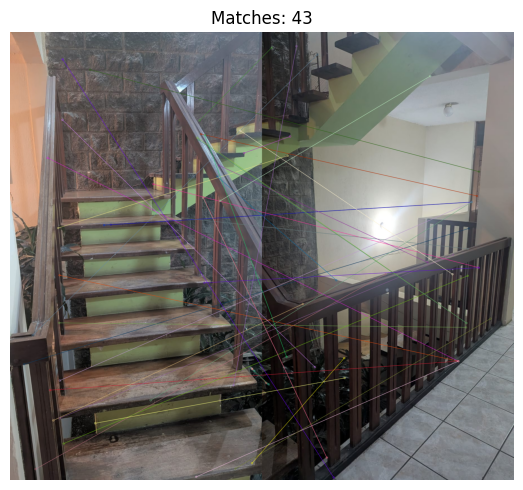

Inliers RANSAC: 8/43


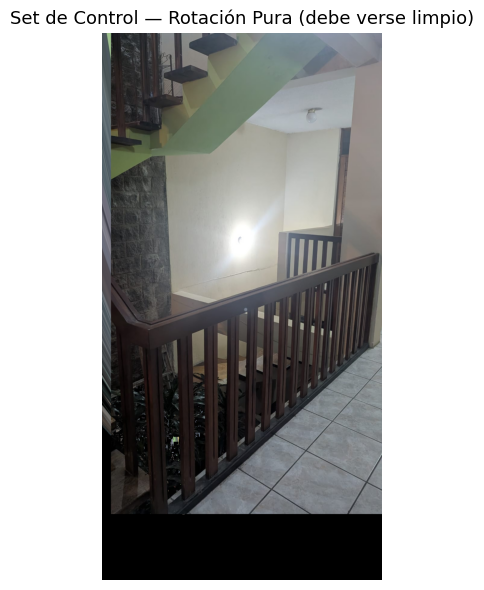

In [42]:
print("=== SET DE CONTROL ===")
panorama_ctrl, warped_ctrl, ox_ctrl, oy_ctrl = stitch_images(ctrl_left, ctrl_right)

plt.figure(figsize=(18, 6))
plt.imshow(cv2.cvtColor(panorama_ctrl, cv2.COLOR_BGR2RGB))
plt.title('Set de Control — Rotación Pura (debe verse limpio)', fontsize=13)
plt.axis('off'); plt.tight_layout()
plt.savefig('panorama_control.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Task 1 – Set Experimental (Traslación Lateral)

=== SET EXPERIMENTAL ===
Keypoints — Izq (Train): 2291 | Der (Query): 2086
Buenos matches: 214


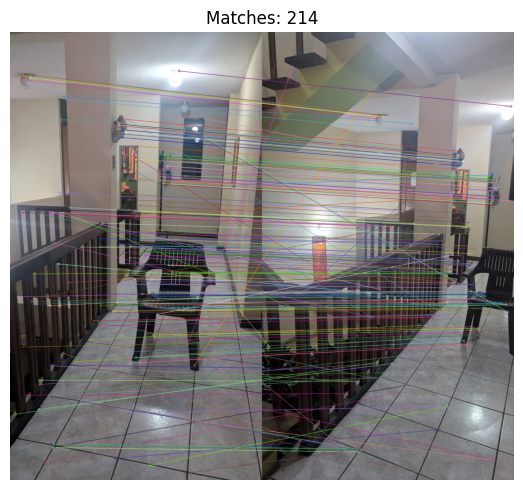

Inliers RANSAC: 66/214


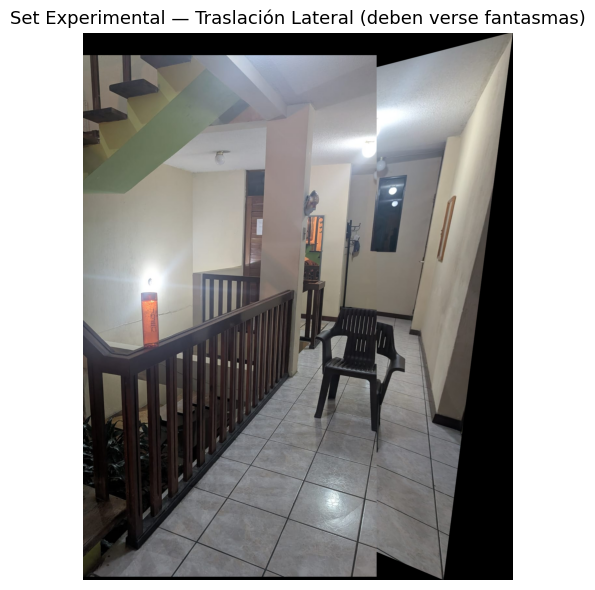

In [43]:
print("=== SET EXPERIMENTAL ===")
panorama_exp, warped_exp, ox_exp, oy_exp = stitch_images(exp_left, exp_right)

plt.figure(figsize=(18, 6))
plt.imshow(cv2.cvtColor(panorama_exp, cv2.COLOR_BGR2RGB))
plt.title('Set Experimental — Traslación Lateral (deben verse fantasmas)', fontsize=13)
plt.axis('off'); plt.tight_layout()
plt.savefig('panorama_experimental.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Task 2.1 – Anaglifo (Visualización del Error)
Rojo = imagen base (izquierda) | Cian = imagen warped (derecha transformada)

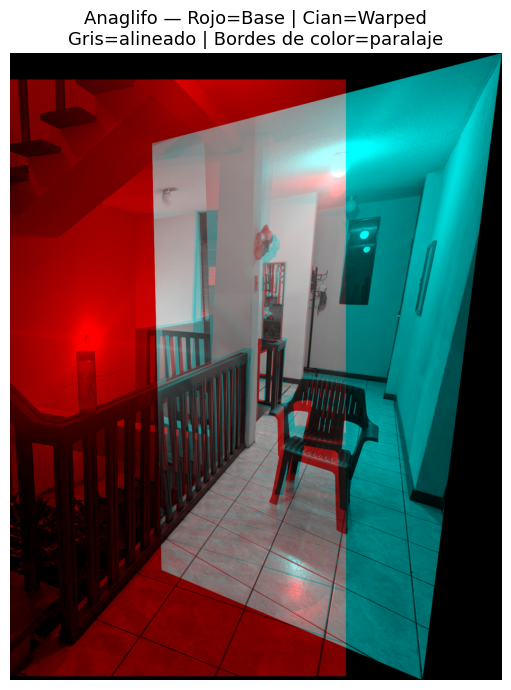

Guardado: anaglyph_error.png


In [44]:
def create_anaglyph(img_base, img_warped):
    gray_base   = cv2.cvtColor(img_base,   cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    gray_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    # Ignorar zonas negras (sin información)
    mask_base   = gray_base   > 0.01
    mask_warped = gray_warped > 0.01

    anaglyph = np.zeros((*img_base.shape[:2], 3), dtype=np.float32)
    anaglyph[:,:,0] = gray_base    # R = base
    anaglyph[:,:,1] = gray_warped  # G = warped
    anaglyph[:,:,2] = gray_warped  # B = warped
    return (np.clip(anaglyph, 0, 1) * 255).astype(np.uint8)


# Poner img_left en el canvas del panorama
h_el, w_el = exp_left.shape[:2]
base_canvas = np.zeros_like(warped_exp)
base_canvas[oy_exp:oy_exp+h_el, ox_exp:ox_exp+w_el] = exp_left

anaglyph_img = create_anaglyph(base_canvas, warped_exp)

plt.figure(figsize=(18, 7))
plt.imshow(anaglyph_img)
plt.title('Anaglifo — Rojo=Base | Cian=Warped\nGris=alineado | Bordes de color=paralaje', fontsize=13)
plt.axis('off'); plt.tight_layout()
plt.savefig('anaglyph_error.png', dpi=150, bbox_inches='tight')
plt.show()
print("Guardado: anaglyph_error.png")

---
## Task 2.2 – Medición de Disparidad

### Paso 1: Hacer zoom en el anaglifo para leer coordenadas

Ejecuta la celda siguiente para ver el anaglifo con zoom en cada objeto.
Luego **anota las coordenadas X** de los dos fantasmas (rojo y cian) de cada objeto.

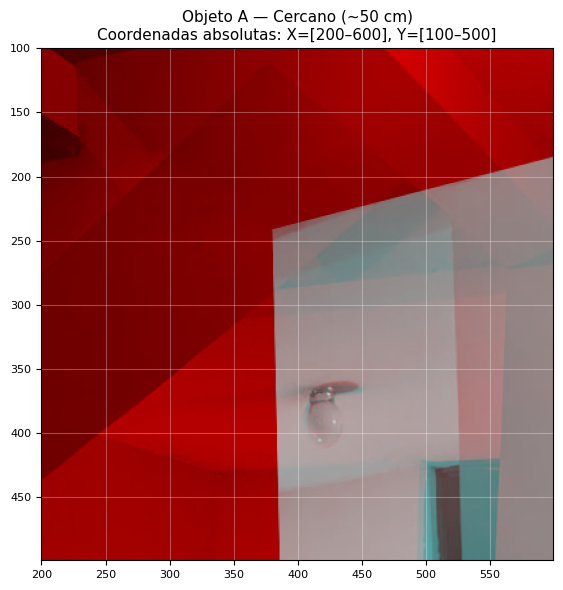

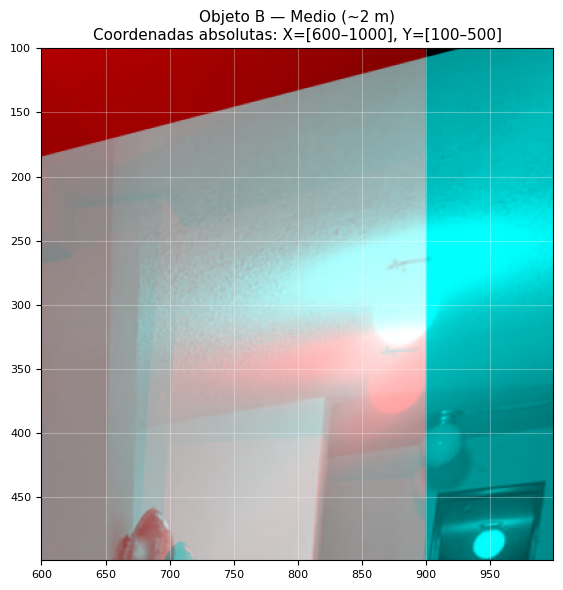

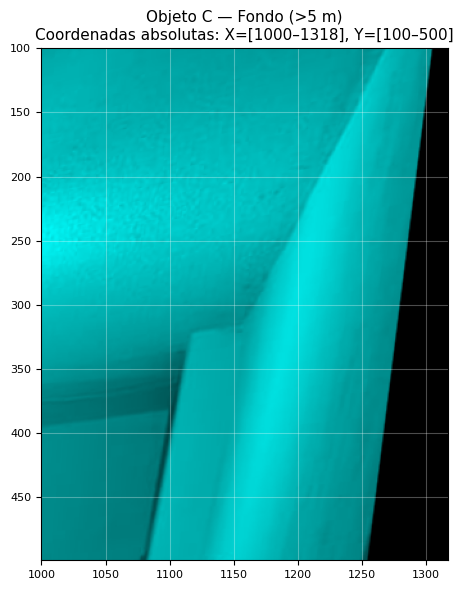

In [45]:
def mostrar_zoom(img, titulo, x_center, y_center, ventana=200):
    """
    Muestra una región del anaglifo centrada en (x_center, y_center).
    Útil para leer coordenadas con precisión.
    """
    h, w = img.shape[:2]
    x0 = max(0, x_center - ventana)
    x1 = min(w, x_center + ventana)
    y0 = max(0, y_center - ventana)
    y1 = min(h, y_center + ventana)

    region = img[y0:y1, x0:x1]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(region)
    ax.set_title(f'{titulo}\nCoordenadas absolutas: X=[{x0}–{x1}], Y=[{y0}–{y1}]', fontsize=11)

    # Ticks en coordenadas absolutas
    xticks = np.arange(0, x1-x0, 50)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x0 + t) for t in xticks], fontsize=8)
    yticks = np.arange(0, y1-y0, 50)
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(y0 + t) for t in yticks], fontsize=8)
    ax.grid(True, alpha=0.3, color='white')
    plt.tight_layout()
    plt.show()


CENTRO_A = (400, 300)   # (x, y) aproximado del Objeto A (Cercano)
CENTRO_B = (800, 300)   # (x, y) aproximado del Objeto B (Medio)
CENTRO_C = (1200, 300)  # (x, y) aproximado del Objeto C (Fondo)

mostrar_zoom(anaglyph_img, 'Objeto A — Cercano (~50 cm)', *CENTRO_A)
mostrar_zoom(anaglyph_img, 'Objeto B — Medio (~2 m)',     *CENTRO_B)
mostrar_zoom(anaglyph_img, 'Objeto C — Fondo (>5 m)',     *CENTRO_C)

### Paso 2: Ingresa las coordenadas que leíste del zoom

In [46]:
resultados = {
    'A (Cercano)': {'dist_real': 0.50, 'x1': 200.0,  'x2': 600.0},
    'B (Medio)':   {'dist_real': 2.00, 'x1': 600.0,  'x2': 1000.0},
    'C (Fondo)':   {'dist_real': 5.00, 'x1': 1000.0,  'x2': 1320.0},
}

# Calcular disparidad y mostrar tabla
for nombre, r in resultados.items():
    r['disparidad'] = abs(r['x1'] - r['x2'])

print(f"{'Objeto':<15} {'Dist. Real':>12} {'X Fantasma 1':>14} {'X Fantasma 2':>14} {'Disparidad (px)':>16}")
print("-" * 75)
for nombre, r in resultados.items():
    print(f"{nombre:<15} {r['dist_real']:>11.2f}m {r['x1']:>14.1f} {r['x2']:>14.1f} {r['disparidad']:>16.1f}")

Objeto            Dist. Real   X Fantasma 1   X Fantasma 2  Disparidad (px)
---------------------------------------------------------------------------
A (Cercano)            0.50m          200.0          600.0            400.0
B (Medio)              2.00m          600.0         1000.0            400.0
C (Fondo)              5.00m         1000.0         1320.0            320.0


---
## Task 3 – Gráfica: Disparidad vs Profundidad

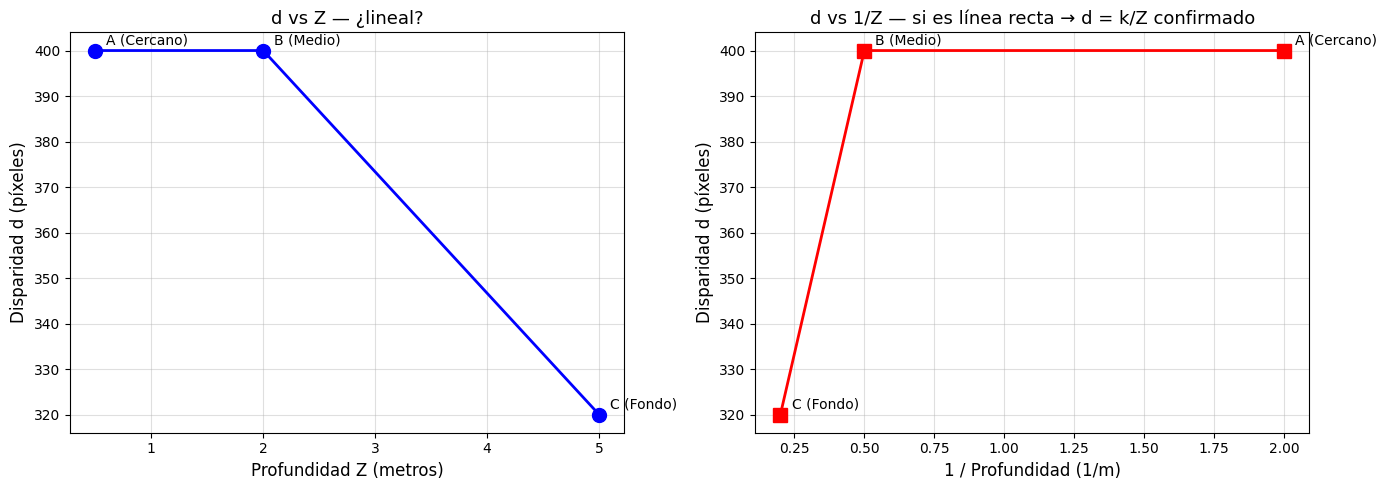

Guardado: disparidad_vs_profundidad.png


In [47]:
nombres      = list(resultados.keys())
distancias   = [r['dist_real']   for r in resultados.values()]
disparidades = [r['disparidad']  for r in resultados.values()]
inv_dist     = [1.0/z            for z in distancias]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1: d vs Z
axes[0].plot(distancias, disparidades, 'bo-', markersize=10, linewidth=2)
for i, n in enumerate(nombres):
    axes[0].annotate(n, (distancias[i], disparidades[i]),
                     textcoords='offset points', xytext=(8,4), fontsize=10)
axes[0].set_xlabel('Profundidad Z (metros)', fontsize=12)
axes[0].set_ylabel('Disparidad d (píxeles)', fontsize=12)
axes[0].set_title('d vs Z — ¿lineal?', fontsize=13)
axes[0].grid(True, alpha=0.4)

# Gráfica 2: d vs 1/Z  (si se lineariza → relación inversa confirmada)
axes[1].plot(inv_dist, disparidades, 'rs-', markersize=10, linewidth=2)
for i, n in enumerate(nombres):
    axes[1].annotate(n, (inv_dist[i], disparidades[i]),
                     textcoords='offset points', xytext=(8,4), fontsize=10)
axes[1].set_xlabel('1 / Profundidad (1/m)', fontsize=12)
axes[1].set_ylabel('Disparidad d (píxeles)', fontsize=12)
axes[1].set_title('d vs 1/Z — si es línea recta → d = k/Z confirmado', fontsize=13)
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.savefig('disparidad_vs_profundidad.png', dpi=150, bbox_inches='tight')
plt.show()
print("Guardado: disparidad_vs_profundidad.png")

---
## Descargar resultados

In [48]:
from google.colab import files

for fname in ['panorama_control.png', 'panorama_experimental.png',
              'anaglyph_error.png', 'disparidad_vs_profundidad.png']:
    try:
        files.download(fname)
    except Exception as e:
        print(f"No se pudo descargar {fname}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>